# Urbanization Trends Analysis using NASA's Black Marble VNP46A4 Data

In [1]:
# Import packages
import os
import datetime
import h5py
import numpy as np
import matplotlib.pyplot as plt

## Obtain list of all HDF5 files

In [2]:
filepaths = []
DATA_DIR = "./data/yearly/"
for filepath in os.listdir(DATA_DIR):
    if filepath.endswith(".h5"):
        filepaths.append(os.path.join(DATA_DIR, filepath))

## Determine datasets to use

In [3]:
filepath = h5py.File(filepaths[0], 'r')
datasets = []
filepath.visit(datasets.append)
datasets

['HDFEOS',
 'HDFEOS/ADDITIONAL',
 'HDFEOS/ADDITIONAL/FILE_ATTRIBUTES',
 'HDFEOS/GRIDS',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Num',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Quality',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Covered_Std',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Num',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Quality',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/AllAngle_Composite_Snow_Free_Std',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/DNB_Platform',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/Land_Water_Mask',
 'HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/NearNadir_

Since the Philippines does not experience snow, we will use the `NearNadir_Composite_Snow_Free` dataset. This is a composite of all the images taken during the dry season. The `Land_Water_Mask` will be used to mask out the water bodies.

In [4]:
# Define dataset paths
BASE_PATH = "HDFEOS/GRIDS/VIIRS_Grid_DNB_2d/Data Fields/"
RADIANCE_DATASET = BASE_PATH + "NearNadir_Composite_Snow_Free"
LANDWATER_MASK_DATASET = BASE_PATH + "Land_Water_Mask"

## Define functions to read data from HDF5 files

In [5]:
def get_radiance_data(hdf5_file, top=None, left=None, bottom=None, right=None):
    return hdf5_file[RADIANCE_DATASET][left:right, top:bottom]

In [6]:
def get_mask_data(hdf5_file, top=None, left=None, bottom=None, right=None):
    mask_data = hdf5_file[LANDWATER_MASK_DATASET][left:right, top:bottom]
    mask_data[mask_data != 255] = 0  # Set land to 0
    mask_data[mask_data == 255] = 1  # Set water to 1

    return mask_data

In [7]:
def get_file_info(filepath):
    """Returns a dictionary containing the file's metadata.

    Filepaths are expected to be in the format:
    VNP46AX.AYYYYDDD.hXXvYY.CCC.YYYYDDDHHMMSS.h5
    """
    filename = os.path.basename(filepath)
    filename_parts = filename.split(".")
    short_name = filename_parts[0]

    # Convert acquisition date to readable format
    acquisition_date = datetime.datetime.strptime(filename_parts[1], "A%Y%j")

    tile_id = filename_parts[2]
    collection_version = filename_parts[3]

    # Convert production date to readable format
    production_date = datetime.datetime.strptime(
        filename_parts[4], "%Y%j%H%M%S"
    )

    return {
        "filename": filename,
        "short_name": short_name,
        "acquisition_date": acquisition_date,
        "tile_id": tile_id,
        "collection_version": collection_version,
        "production_date": production_date,
    }

## Display sample images

In [8]:
# Define bounding box for the area of interest
box = {"top": 200, "left": 1200, "bottom": 350, "right": 1450}

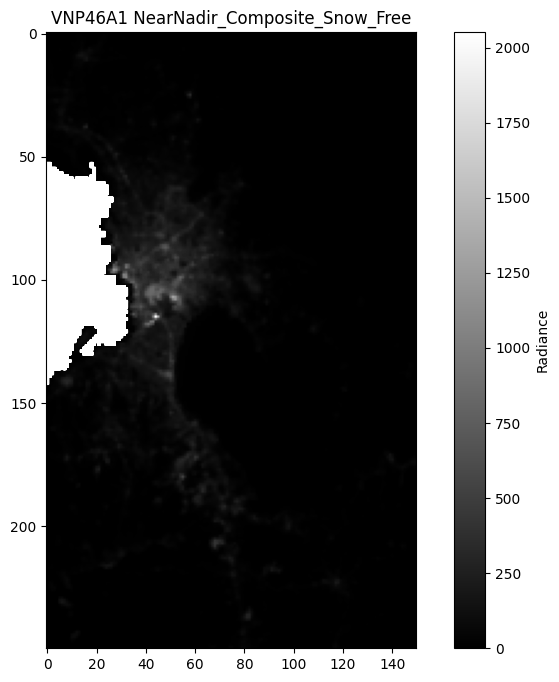

In [9]:
with h5py.File(filepaths[0], "r") as filepath:
    radiance_data = get_radiance_data(filepath, **box)
    mask_data = get_mask_data(filepath, **box)

# Display the data using matplotlib
plt.figure(figsize=(10, 8))
plt.imshow(
    radiance_data,
    cmap="gray",
    vmin=0,
    vmax=np.max(radiance_data[mask_data == 0]),
)
plt.colorbar(label="Radiance")
plt.title("VNP46A1 NearNadir_Composite_Snow_Free")
plt.show()

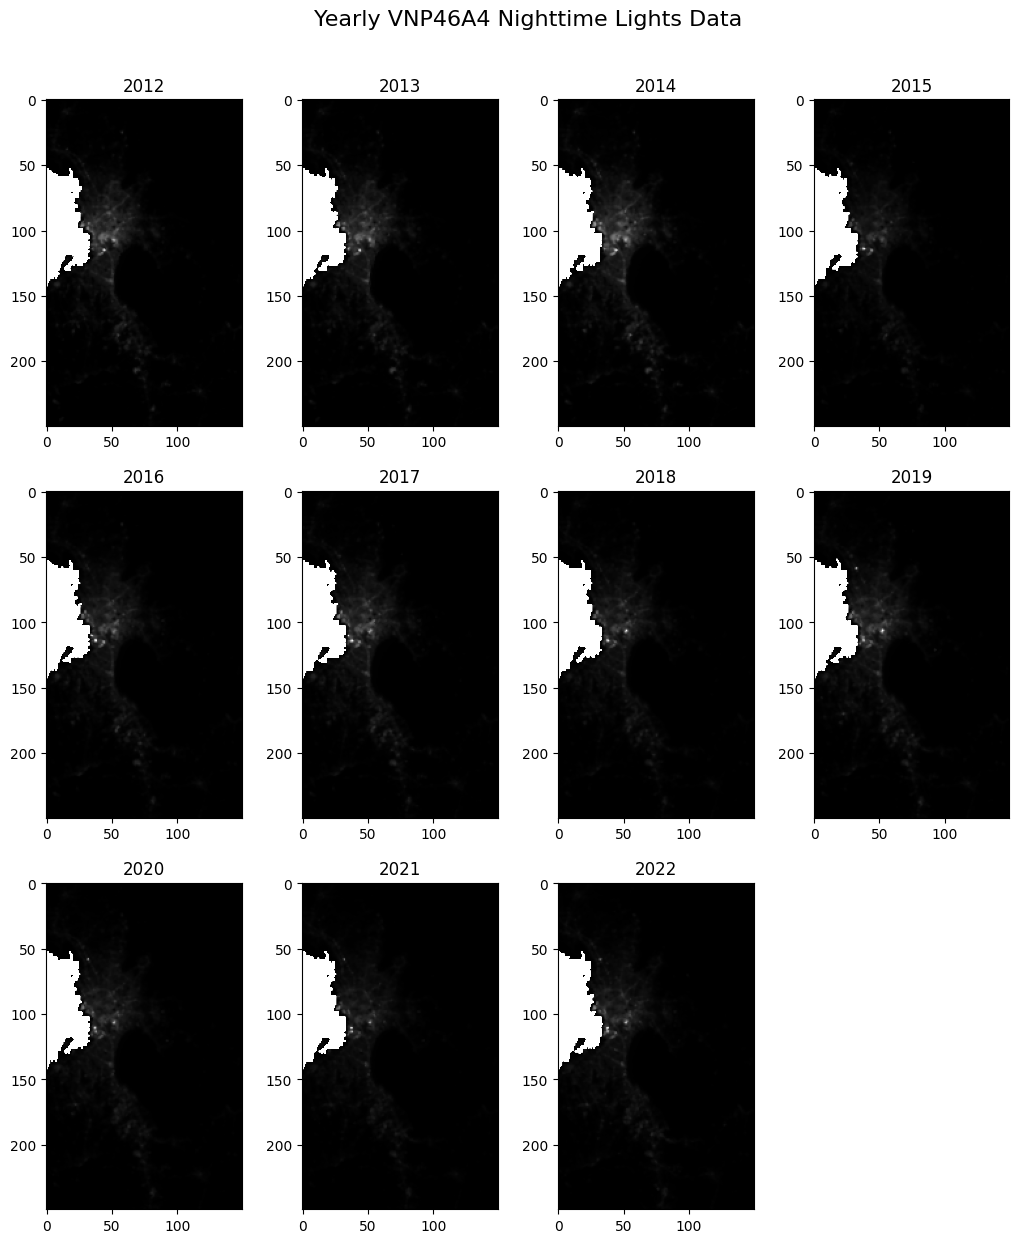

In [10]:
# Use matplotlib to display a 4x3 grid of 11 images
fig, axs = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(
    "Yearly VNP46A4 Nighttime Lights Data",
    fontsize=16,
    x=0.3,
    y=0.9,
)
fig.delaxes(axs[2, 3])  # Remove the last subplot

for i, filepath in enumerate(filepaths):
    with h5py.File(filepath, "r") as hdf5_file:
        radiance_data = get_radiance_data(hdf5_file, **box)
        mask_data = get_mask_data(hdf5_file, **box)

    max_radiance = np.max(radiance_data[mask_data == 0])
    axs[i // 4, i % 4].imshow(
        radiance_data, cmap="gray", vmin=0, vmax=max_radiance
    )

    year_acquired = get_file_info(filepath)["acquisition_date"].year
    axs[i // 4, i % 4].set_title(year_acquired, fontsize=12)

plt.subplots_adjust(
    left=0.05, right=0.55, bottom=0.1, top=0.84, wspace=0.1, hspace=0.2
)

# Show trends of night lights in Manila, Philippines

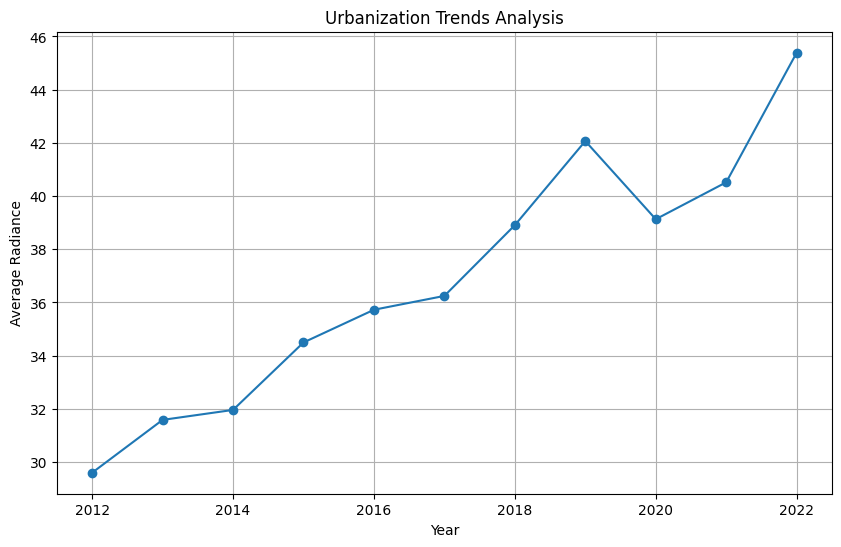

In [11]:
# Initialize arrays to store data
years = np.arange(2012, 2023)
urbanization_trends = []

for i, filepath in enumerate(filepaths):
    with h5py.File(filepath, "r") as filepath:
        radiance_data = get_radiance_data(filepath, **box)
        mask_data = get_mask_data(filepath, **box)
    average_radiance = np.mean(radiance_data[mask_data == 0])
    urbanization_trends.append(average_radiance)
    
# Convert the list to a numpy array
urbanization_trends = np.array(urbanization_trends)

# Plot the urbanization trends
plt.figure(figsize=(10, 6))
plt.plot(years, urbanization_trends, marker="o")
plt.title("Urbanization Trends Analysis")
plt.xlabel("Year")
plt.ylabel("Average Radiance")
plt.grid(True)
plt.show()